In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

# 구글드라이브 활용한 데이터 불러오기

In [ ]:
#구글드라이브를 활용해 데이터 불러오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_ = Path('//content/drive/MyDrive/Data_for_training/Woman')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
   
#이미지데이터의 경로와 label데이터로 데이터프레임 만들기 


    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,//content/drive/MyDrive/Data_for_training/Woma...,formal
1,//content/drive/MyDrive/Data_for_training/Woma...,girlish
2,//content/drive/MyDrive/Data_for_training/Woma...,girlish
3,//content/drive/MyDrive/Data_for_training/Woma...,girlish
4,//content/drive/MyDrive/Data_for_training/Woma...,formal


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1919

Number of different labels: 9

Labels: ['formal' 'girlish' 'golf' 'street' 'casual' 'romantic' 'chic' 'sports'
 'retro']


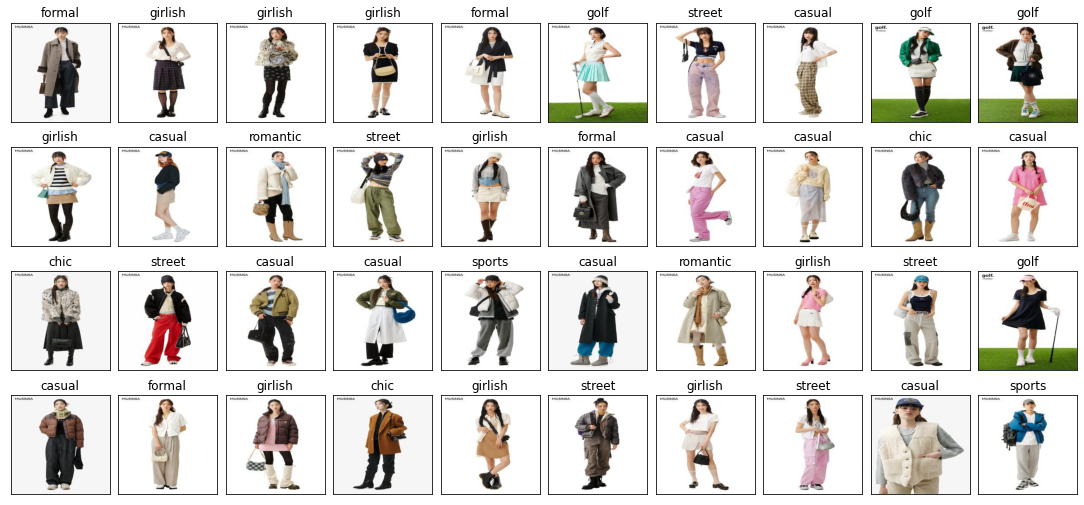

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

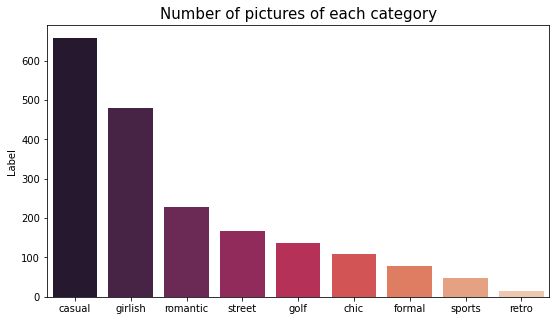

In [ ]:
## 여자 데이터 분포 확인
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((1727, 2), (192, 2))

In [ ]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 1382 validated image filenames belonging to 9 classes.
Found 345 validated image filenames belonging to 9 classes.


모델 전처리

In [ ]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=9, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [ ]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
44/44 [==============================] - 1291s 29s/step - loss: 2.0301 - accuracy: 0.3452 - val_loss: 1.6116 - val_accuracy: 0.3971
Epoch 2/10
44/44 [==============================] - 4s 94ms/step - loss: 1.3849 - accuracy: 0.5123 - val_loss: 1.3333 - val_accuracy: 0.5565
Epoch 3/10
44/44 [==============================] - 4s 92ms/step - loss: 1.1185 - accuracy: 0.6100 - val_loss: 1.3038 - val_accuracy: 0.5507
Epoch 4/10
44/44 [==============================] - 4s 93ms/step - loss: 0.8228 - accuracy: 0.7069 - val_loss: 1.3756 - val_accuracy: 0.5739
Epoch 5/10
44/44 [==============================] - 4s 91ms/step - loss: 0.5714 - accuracy: 0.8104 - val_loss: 1.4834 - val_accuracy: 0.5217
Epoch 6/10
44/44 [==============================] - 4s 96ms/step - loss: 0.3641 - accuracy: 0.8842 - val_loss: 1.5738 - val_accuracy: 0.5565
Epoch 7/10
44/44 [==============================] - 5s 107ms/step - loss: 0.1983 - accuracy: 0.9537 - val_loss: 1.8521 - val_accuracy: 0.5188
Epoch 8/10

In [ ]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
    # 라벨 개수가 9개이기 때문에 Dencs도 9로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 1555 validated image filenames belonging to 9 classes.
Found 172 validated image filenames belonging to 9 classes.
Found 192 validated image filenames belonging to 9 classes.


29084464/29084464 [==============================] - 2s 0us/step
DenseNet121          trained in 15.92 sec
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 8.5 sec
74836368/74836368 [==============================] - 4s 0us/step
DenseNet201          trained in 23.23 sec
16705208/16705208 [==============================] - 2s 0us/step
EfficientNetB0       trained in 12.19 sec
27018416/27018416 [==============================] - 2s 0us/step
EfficientNetB1       trained in 15.0 sec
87910968/87910968 [==============================] - 5s 0us/step
InceptionV3          trained in 12.83 sec
12683000/12683000 [==============================] - 2s 0us/step
MobileNetV3Large     trained in 9.48 sec
234545216/234545216 [==============================] - 11s 0us/step
ResNet

# Test 데이터로 모델 성능 측정

In [ ]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

6/6 [==============================] - 117s 23s/step
**DenseNet121 has a 59.38% accuracy on the test set**
6/6 [==============================] - 1s 89ms/step
**MobileNetV2 has a 61.98% accuracy on the test set**
6/6 [==============================] - 3s 149ms/step
**DenseNet201 has a 61.46% accuracy on the test set**
6/6 [==============================] - 2s 89ms/step
**EfficientNetB0 has a 35.42% accuracy on the test set**
6/6 [==============================] - 2s 92ms/step
**EfficientNetB1 has a 35.42% accuracy on the test set**
6/6 [==============================] - 2s 94ms/step
**InceptionV3 has a 47.40% accuracy on the test set**
6/6 [==============================] - 2s 108ms/step
**MobileNetV3Large has a 35.42% accuracy on the test set**
6/6 [==============================] - 3s 229ms/step
**ResNet152V2 has a 55.73% accuracy on the test set**
6/6 [==============================] - 1s 102ms/step
**ResNet50 has a 35.94% accuracy on the test set**
6/6 [============================

,model,val_accuracy,accuracy,Training time (sec)
0,Xception,0.5756,0.6302,12.92
1,MobileNetV2,0.5581,0.6198,8.50
2,DenseNet201,0.5581,0.6146,23.23
3,DenseNet121,0.5872,0.5938,15.92
4,ResNet50V2,0.5814,0.5938,9.28
5,ResNet152V2,0.5349,0.5573,23.94
6,InceptionV3,0.5116,0.4740,12.83
7,ResNet50,0.3779,0.3594,10.12
8,EfficientNetB0,0.3256,0.3542,12.19
9,EfficientNetB1,0.3256,0.3542,15.00


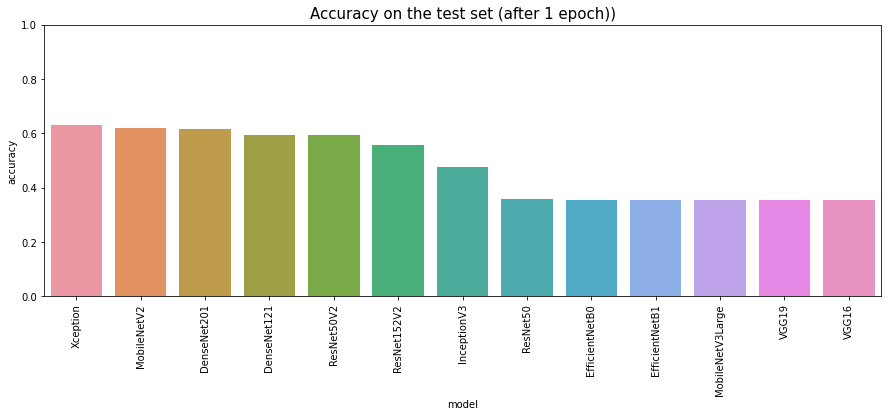

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

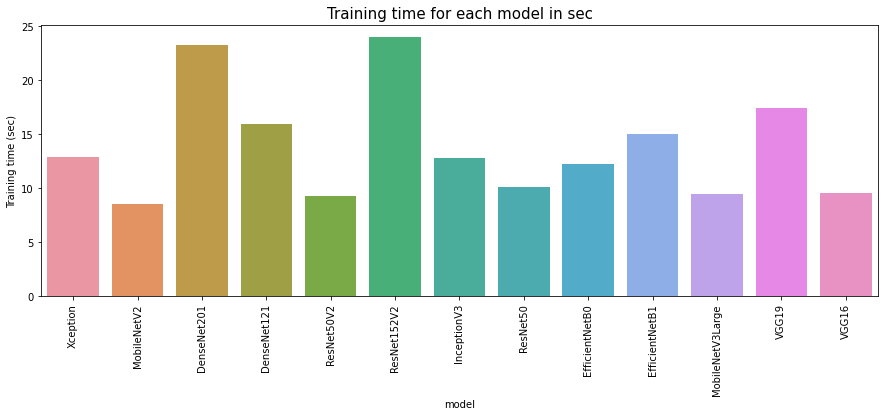

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

### 시간과 성능을 고려하여 선택한 MobileNet의 성능을 재검증

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.MobileNetV2)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 1555 validated image filenames belonging to 9 classes.
Found 172 validated image filenames belonging to 9 classes.
Found 192 validated image filenames belonging to 9 classes.
Epoch 1/7
49/49 [==============================] - 8s 113ms/step - loss: 1.4616 - accuracy: 0.5151 - val_loss: 1.2431 - val_accuracy: 0.5523
Epoch 2/7
49/49 [==============================] - 5s 99ms/step - loss: 1.0806 - accuracy: 0.6225 - val_loss: 1.1176 - val_accuracy: 0.6221
Epoch 3/7
49/49 [==============================] - 5s 98ms/step - loss: 0.9234 - accuracy: 0.6759 - val_loss: 1.1508 - val_accuracy: 0.5698
Epoch 4/7
49/49 [==============================] - 5s 99ms/step - loss: 0.8212 - accuracy: 0.7119 - val_loss: 1.1563 - val_accuracy: 0.5814
Epoch 5/7
49/49 [==============================] - 5s 98ms/step - loss: 0.7762 - accuracy: 0.7125 - val_loss: 1.1049 - val_accuracy: 0.6163
Epoch 6/7
49/49 [==============================] - 5s 99ms/step - loss: 0.6412 - accuracy: 0.7653 - val_loss: 1.1693 -

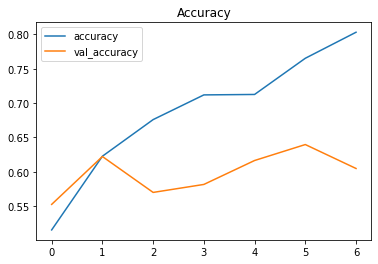

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

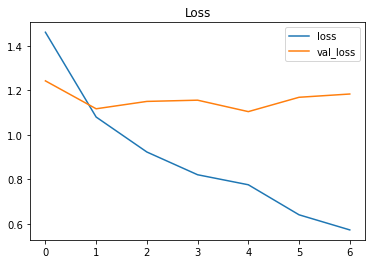

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# 테스트 이미지의 label 예측
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# 라벨 맵핑
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

6/6 [==============================] - 2s 123ms/step
Accuracy on the test set: 67.19%


번호를 입력하세요 : 5
1/1 [==============================] - 0s 18ms/step


## 예측률 : 81.24%

### Class prediction = casual

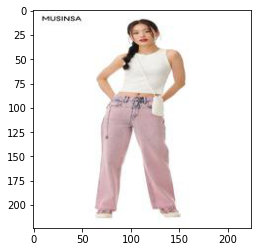

In [ ]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'casual': 0,
                    'chic': 1,
                    'formal': 2,
                    'girlish': 3,
                    'golf': 4,
                    'retro': 5,
                    'romantic': 6,
                    'sports': 7,
                    'street': 8}
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

In [ ]:
model.save('/content/drive/MyDrive/2023 KUIAI 해커톤/koo_woman_ninestyle_classifier.h5')